# PYTHON VERSION

In [1]:
import sys
print(sys.version)

3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)  # increase default figure size

np.random.seed(2016)  # for reproducibility

# Ising Model


In this notebook the **Metropolis-Hastings** algorithm will be used to
sample from the invariant distribution $\pi$ of the [Ising model](https://en.wikipedia.org/wiki/Ising_model). 
In the next code cell a grid of length `L = 32` is considered, 
therefore the space $\mathbb{X}$ of possible configurations has a cardinality of $2^{1024} > 10^{307}$. 
Clearly, sampling from such a large space is practically impossible with conventional methods. 

In [3]:
# Parameters
L = 32  # length of lattice
N = L * L  # number of particles
nsteps = N * 800  # number of updates, we will update each spin 800 times on average 
Temperature = 30.  # in units where the Boltzmann factor is 1

# Initialize Variables
spins = 2 * (np.random.rand(L, L) > 0.5) - 1  # random initial state (table of {1, -1})
kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

for n in range(nsteps):
    r, c = np.random.randint(0, L, 2)  # select a vertex (row, column) at random
    # indices of a box around r, c
    C = [(c-1) % L, c % L, (c + 1) % L]  # periodic boundary conditions, i.e. (0,x) is a neighbour of (L-1,x) 
    R = [[(r-1) % L], [r % L], [(r+1) % L]]
    DH = spins[r, c] * np.sum(kernel * spins[R, C]) 
    if np.random.rand() < np.exp(- DH / Temperature):  
        spins[r, c] *= -1  # flip spin 


The code uses the Metropolis-Hastings algorithm 
to simulate a Markovian chain on $\mathbb{X}$ 
starting from a random initial configuration (`spins`) and having an invariant distribution of the [Gibbs measure](https://en.wikipedia.org/wiki/Gibbs_measure) corresponding to the energy of the Ising model, i.e.

$$H(\sigma)=-\sum_{x,y: x~y} \sigma(x)\sigma(y)$$
and
$$\pi(\sigma)=\frac{e^{-\beta H(\sigma)}}{Z(\beta)}$$
where the partition function $Z(\beta)$ is given by
$$Z(\beta)=\sum_{\sigma\in\mathbb{X}} e^{-\beta H(\sigma)}.$$


In each iteration (`nsteps`)
randomly selects a point on the grid (`r, c`) and calculates the difference in energy 
of the system (`DH`) if the spin at that point changes sign. 
It then accepts or rejects the spin change with probability $e^{-\beta (DH)^+}$, as defined by the Metropolis-Hastings algorithm.

In the next code cell the final state of the system is visualized.

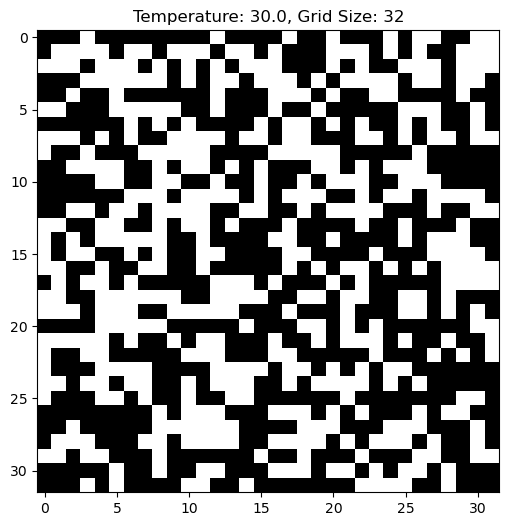

In [4]:
plt.imshow(spins, cmap='binary', vmin=-1, vmax=1, interpolation='nearest')
plt.title("Temperature: %.1f, Grid Size: %d" % (Temperature, L))
plt.show()

### Ising Parameters

To get a better intuition of how the system works, its behavior will be studied by tweaking the various parameters.

First the question of how energy affects the probability of spin change will be studied.
In the code cell below the transition probability for all the
possible energy values is plotted.

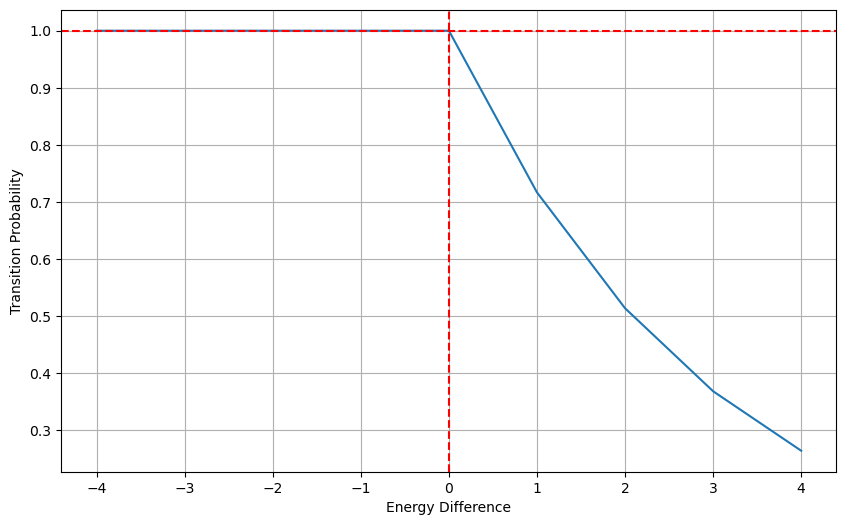

In [5]:
x = np.arange(-4, 5)  # all possible DH after a spin flip
Temperature = 3.0
y = np.exp(-np.maximum(x,0) / Temperature)  
plt.plot(x, y)
plt.xlabel("Energy Difference")
plt.ylabel("Transition Probability")
plt.grid(True)
plt.axvline(0, color='red', linestyle='dashed')
plt.axhline(1, color='red', linestyle='dashed')
plt.show()

Notice that when the energy of the system decreases (`DH < 0`),
the algorithm automatically accepts the proposed change. On the contrary, when the system energy increases,
the algorithm does not immediately reject the change but accepts it with decreasing probability.

In the next code various temperatures are tested to see how they affect
the probability of a spin change.

/tmp/ipykernel_8499/952834474.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Dark2')


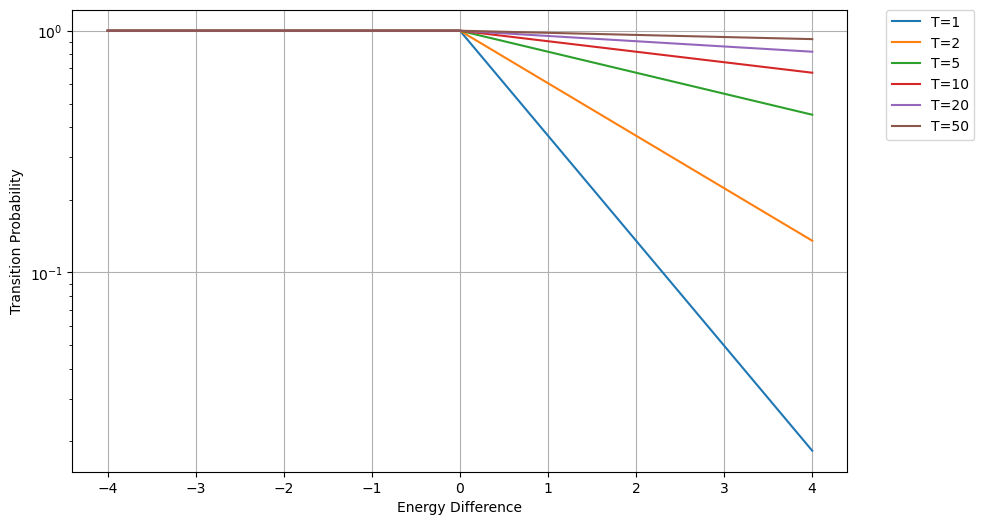

In [6]:
temperatures = [1, 2, 5, 10, 20, 50]
cmap = plt.cm.get_cmap('Dark2')
colors = [cmap(x) for x in np.linspace(0, 1, 6)]

for col, temp in zip(colors, temperatures):
    y = np.exp(-np.maximum(x,0) / temp)
    plt.semilogy(x, y, label='T=%d' % temp)

plt.xlabel("Energy Difference")
plt.ylabel("Transition Probability")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

Notice how temperature (`T`) "controls" the slope of the logarithm of the transition probability.
A small temperature (and therefore a large slope) means that the chain is very sensitive
to changes in energy, so the only changes it will accept are those that
decrease the energy of the system or increase it only slightly. In contrast, a high temperature
(and therefore a small gradient) means that the chain is essentially indifferent to
the energy of the system and accepts any proposed change since, as we can see
the probability of a spin change is close to one.

### Ising Animation

For the next code cell the script `animate_ising.py` is required. This script visualizes dynamically the evolution of the spin grid.

It takes 3 arguments

1. `-L`: the size of the lattice
2. `-Temp`: the temperature
3. `-up`: the percentage of spins that are initially positive

Try running the following cell after deleting `#` from the first 2 lines
depending on your operating system. If it does not run, open a command window (Terminal) and from the folder where you have saved the `animate_ising.py` file and type the command `python3 animate_ising.py -T 0.1 -L 32 -up 0.5`.

/workspaces/miniconda/Modules/animate_ising.py:55: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = animation.FuncAnimation(fig, updatefig,


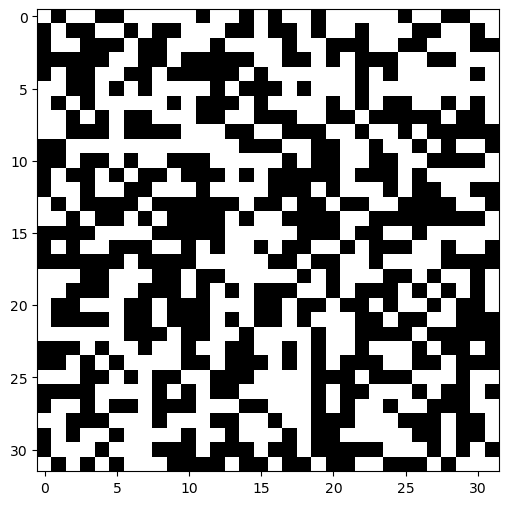

<Figure size 1000x600 with 0 Axes>

In [9]:
run Modules/animate_ising.py -T 0.1 -L 32 -up 0.5

But let the program run long enough to see the system end up to a state where th spins are either (almost) all +1, or (almost) all -1.

In the following code cell the `Ising` function is given and it can be executed provided 

1. The initial state of the grid (a numpy array with -1 and 1).
2. The temperature.
3. Optionally, the number of steps.

In [10]:
def Ising(spins_init, Temp, nsteps=None):
    """
    Ising Model.
        spins_init: initial configuration
        Temp: the Temperature
        updates: the number of updates to perform
    """
    spins = spins_init.astype(np.int8)  # copy and save some space :)
    L = spins.shape[0]
    N = L * L
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=np.int8)
    Temp = Temp
    if nsteps is None:
        nsteps = L * L * 800  # number of updates

    for n in range(nsteps):
        r, c = np.random.randint(0, L, 2)  # select a vertex at random
        C = [(c-1) % L, c % L, (c + 1) % L]
        R = [[(r-1) % L], [r % L], [(r+1) % L]]
        DH = -spins[r, c] * np.sum(kernel * spins[R, C]) / Temp
        if np.log(np.random.rand()) < DH:
            spins[r, c] *= -1  # switch sign
    
    return spins

## Application

(a) Try running the code with all spins initially at +1. 

(b) Now start lowering the temperature, successively setting 
T = 30, 10, 5, 2, 1.5, 1., 0.5, 0.1, 0.01. Show for each temperature the picture you got.

The magnetization of the system is defined as the average spins of the lattice $\Lambda$, i.e.

$$ m(\sigma) = \frac{1}{|\Lambda|} \sum_{k \in \Lambda} \sigma(k) $$

(c) Consider how $m(\sigma)$ behaves for the states $\sigma$ 
given by the algorithm as you lower the temperature, as in question (b).
Show a plot of $m(\sigma)$ versus temperature (for the $\sigma$ configuration you simulated).

(d) For the temperature `T = 0.1` change the value of the parameter nsteps. What do the intermediate stages through which the chain passes look like until it reaches the point where it resembles the picture obtained for `nsteps = 800 × L × L`? Show the images you obtained for `nsteps=10,20,50,100,100,200,400,800 × L × L`.

In [11]:
import numpy.matlib

plt.rcParams["figure.figsize"] = (10, 6)  # increase default figure size

np.random.seed(2016)  # for reproducibility

In [12]:
# Application 
# Question (a)
# Parameters
L = 32             # length of lattice
N = L * L          # number of particles
nsteps = N * 800   # number of updates, we will update each spin 800 times on average 
Temperature = 30.  # in units where the Boltzmann factor is 1

# Initialize Variables
spins = np.matlib.ones((L,L))  # initial state (LxLtable of ones)
kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

for n in range(nsteps):
    r, c = np.random.randint(0, L, 2)                  # select a vertex (row, column) at random
    # indices of a box around r, c
    C = [(c-1) % L, c % L, (c + 1) % L]                # periodic boundary conditions, i.e. (0,x) is a neighbour of (L-1,x) 
    R = [[(r-1) % L], [r % L], [(r+1) % L]]
    DH = spins[r, c] * np.sum(kernel * spins[R, C])    
    if np.random.rand() < np.exp(- DH / Temperature):  
        spins[r, c] *= -1  # flip spin 

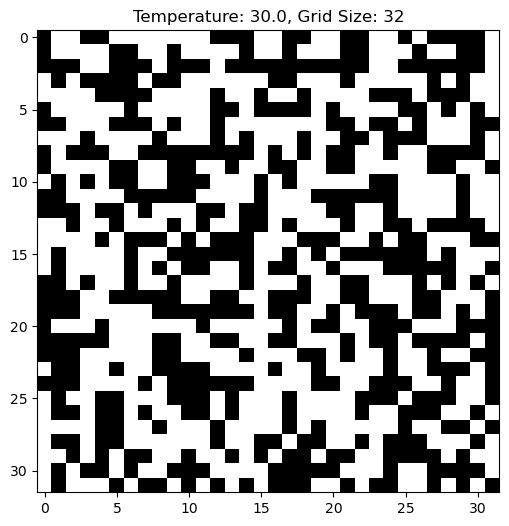

In [13]:
# Plotting
plt.imshow(spins, cmap='binary', vmin=-1, vmax=1, interpolation='nearest')
plt.title("Temperature: %.1f, Grid Size: %d" % (Temperature, L))
plt.show()

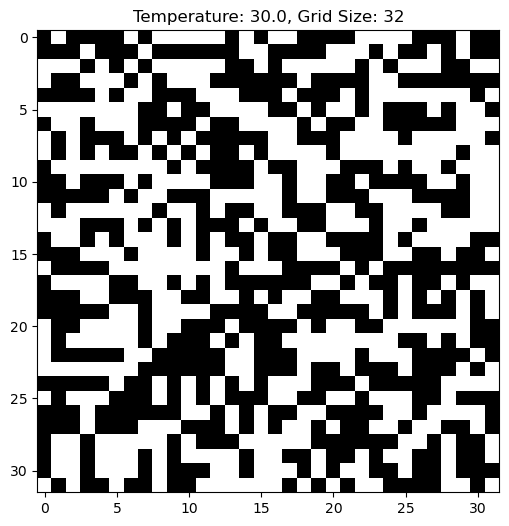

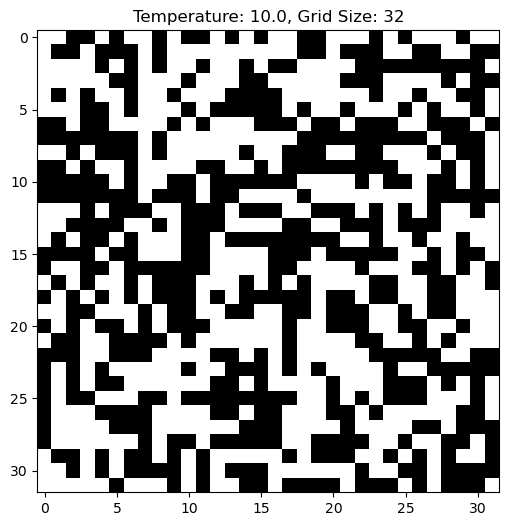

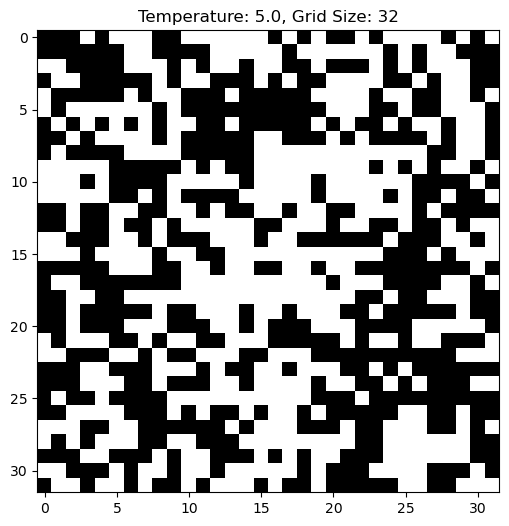

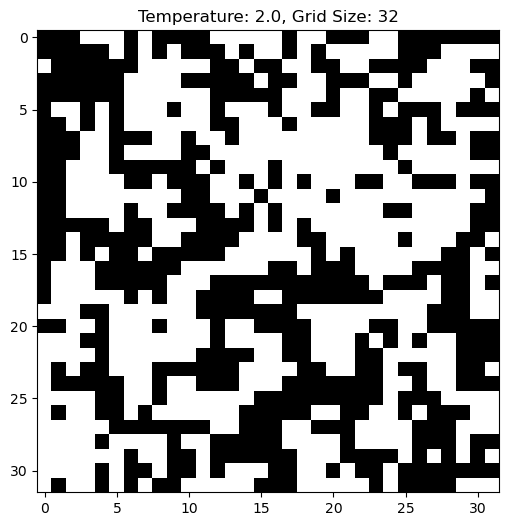

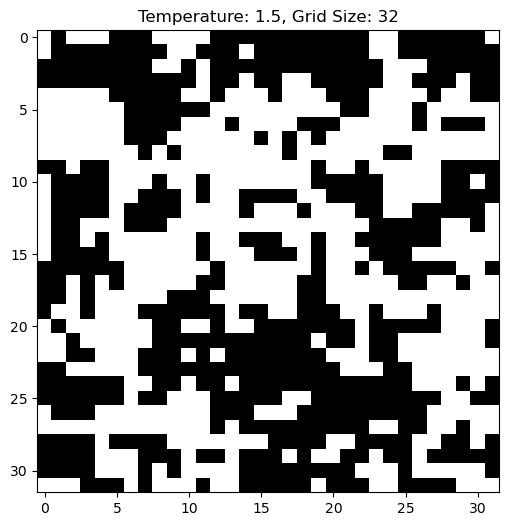

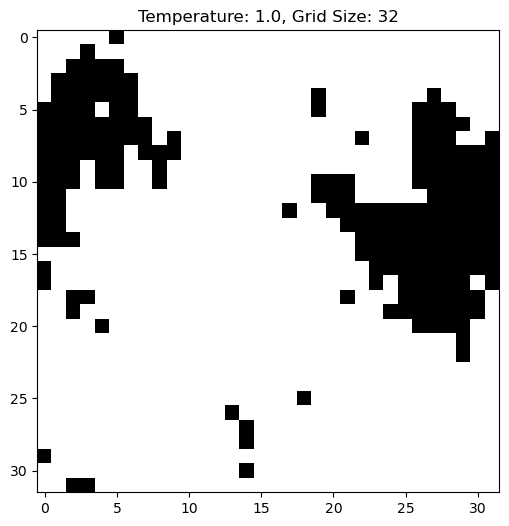

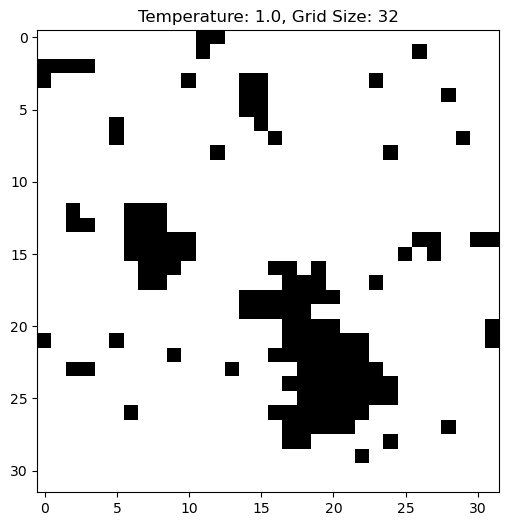

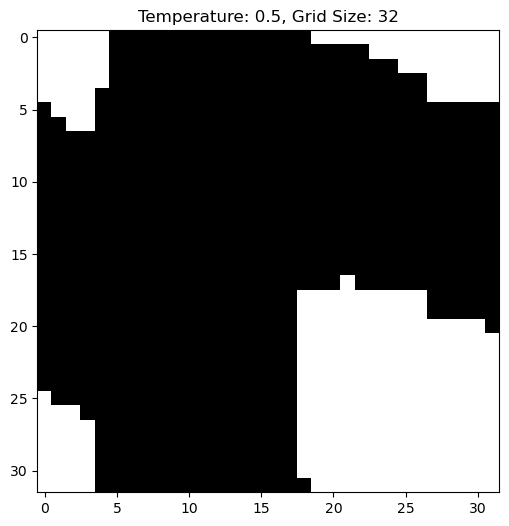

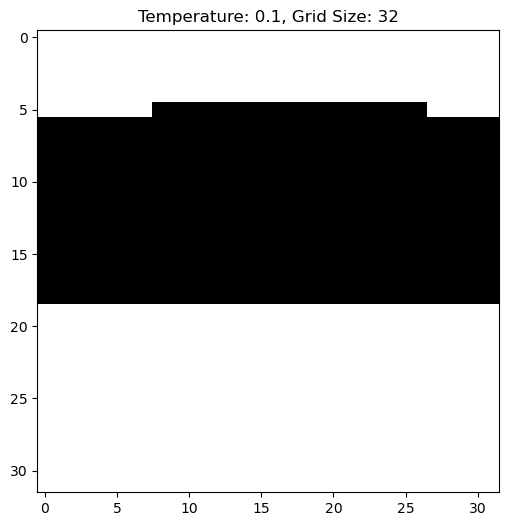

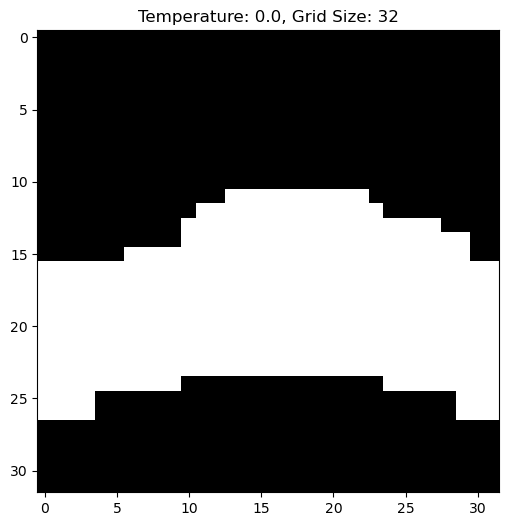

In [14]:
# Question (b)
# Parameters
L = 32               
N           = L * L            
nsteps      = N * 100 # I changed the update-rate
T           = [30, 10, 5, 2, 1.5, 1, 1.0, 0.5, 0.1, 0.01]

for Temperature in T:
    # Initialize Variables
    spins = 2 * (np.random.rand(L, L) > 0.5) - 1  
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

    for n in range(nsteps):
        r, c = np.random.randint(0, L, 2)                  # select a vertex (row, column) at random
        # indices of a box around r, c
        C = [(c-1) % L, c % L, (c + 1) % L]                # periodic boundary conditions, i.e. (0,x) is a neighbour of (L-1,x) 
        R = [[(r-1) % L], [r % L], [(r+1) % L]]
        DH = spins[r, c] * np.sum(kernel * spins[R, C])   
        if np.random.rand() < np.exp(- DH / Temperature):  
            spins[r, c] *= -1  # flip spin 

    # Plotting
    plt.imshow(spins, cmap='binary', vmin=-1, vmax=1, interpolation='nearest')
    plt.title("Temperature: %.1f, Grid Size: %d" % (Temperature, L))
    plt.show()

For Temperature =  30  m(σ) =  0.025390625
For Temperature =  10  m(σ) =  0.048828125
For Temperature =  5  m(σ) =  0.294921875
For Temperature =  2  m(σ) =  1.0
For Temperature =  1.5  m(σ) =  1.0
For Temperature =  1  m(σ) =  1.0
For Temperature =  1.0  m(σ) =  1.0
For Temperature =  0.5  m(σ) =  1.0
For Temperature =  0.1  m(σ) =  1.0
For Temperature =  0.01  m(σ) =  1.0


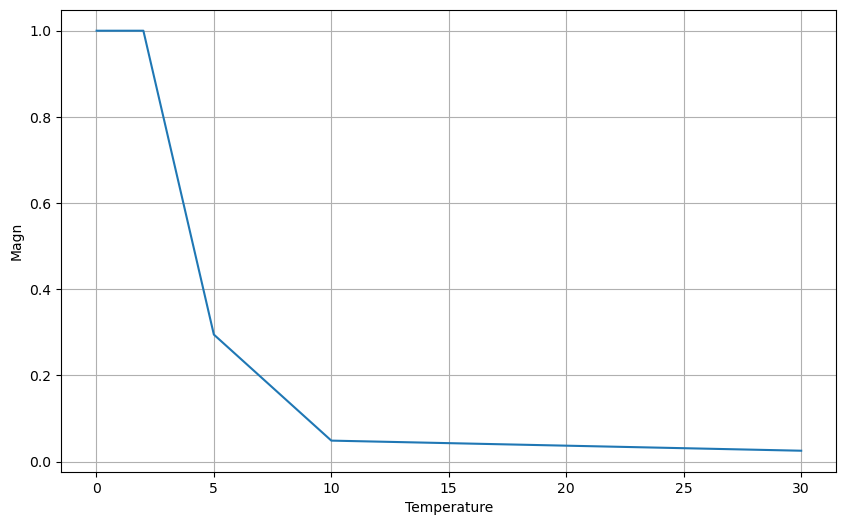

In [15]:
# Question (c)
# Parameters
L = 32               
N           = L * L            
nsteps      = N * 100 # I changed the update-rate to 100
T           = [30, 10, 5, 2, 1.5, 1, 1.0, 0.5, 0.1, 0.01]
M           = []

for Temperature in T:
    # Local Variables
    sum = 0
    # Initialize Variables
    spins  = np.matlib.ones((L,L))  
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

    for n in range(nsteps):
        r, c = np.random.randint(0, L, 2)                  # select a vertex (row, column) at random
        # indices of a box around r, c
        C = [(c-1) % L, c % L, (c + 1) % L]                # periodic boundary conditions, i.e. (0,x) is a neighbour of (L-1,x) 
        R = [[(r-1) % L], [r % L], [(r+1) % L]]
        DH = spins[r, c] * np.sum(kernel * spins[R, C])    
        if np.random.rand() < np.exp(- DH / Temperature):  
            spins[r, c] *= -1  # flip spin 
    for i in range(L):
        for j in range(L):
            sum += spins[i,j]
    m = sum/N
    M.append(m)
    print("For Temperature = ",Temperature," m(σ) = ",m)

# Plotting
plt.plot(T,M, label='Temp - Magn')
plt.xlabel('Temperature')
plt.ylabel('Magn')
plt.grid()

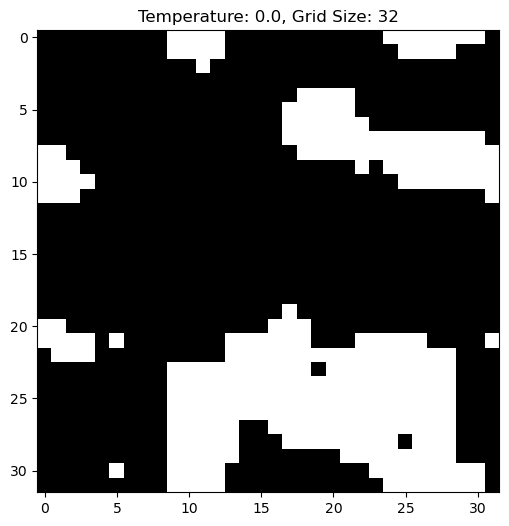

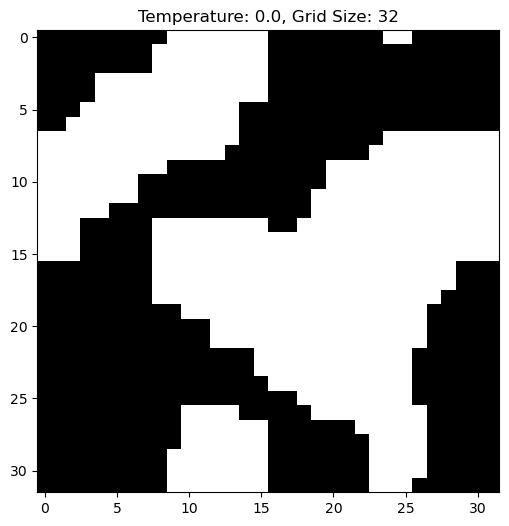

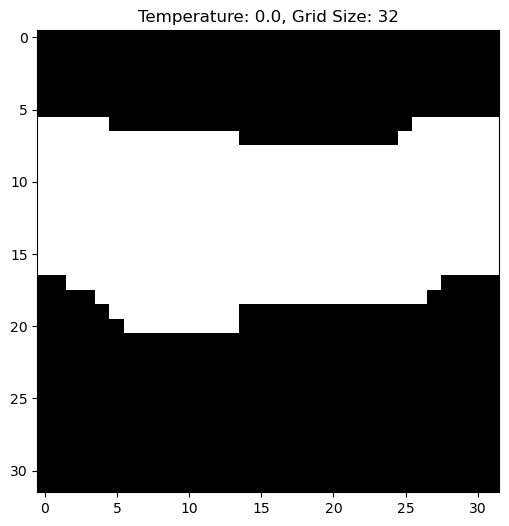

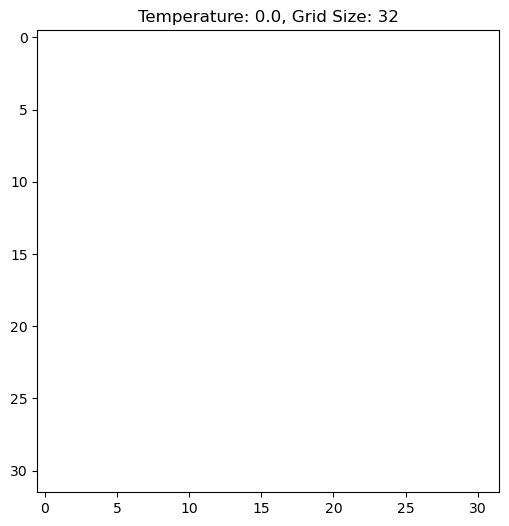

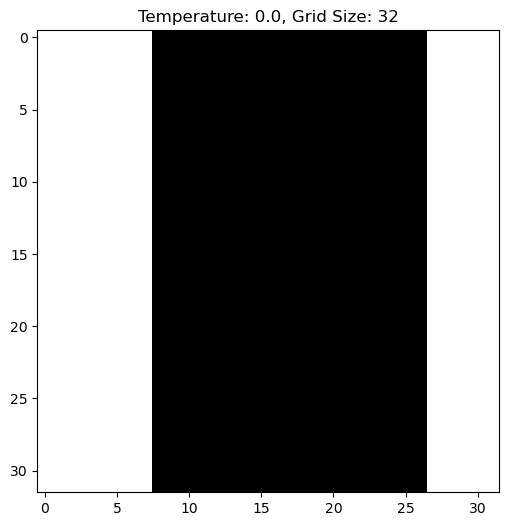

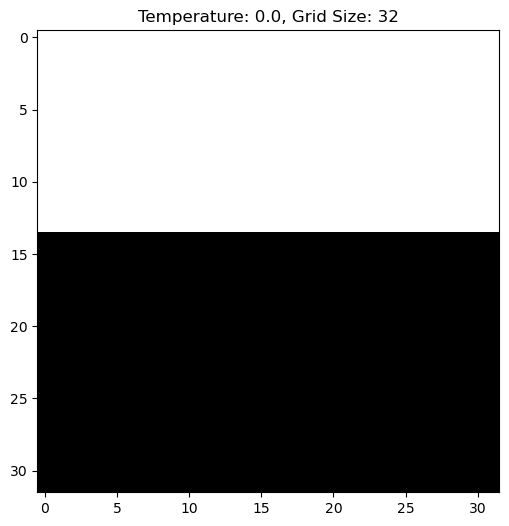

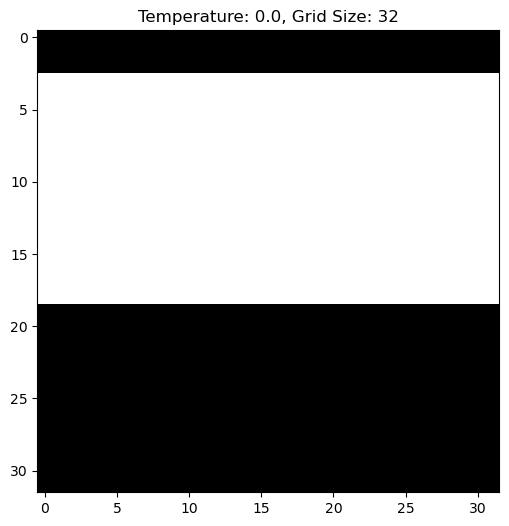

In [16]:
# Question (d)
# Parameters
L = 32               
N = L * L            
T = 0.01
I = [10, 20, 50, 100, 200, 400 ,800]

for i in I:
    # Local Variables
    nsteps = N * i                                         # update-rate = i
    # Initialize Variables
    spins  = 2 * (np.random.rand(L, L) > 0.5) - 1  
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

    for n in range(nsteps):
        r, c = np.random.randint(0, L, 2)                  # select a vertex (row, column) at random
        # indices of a box around r, c
        C = [(c-1) % L, c % L, (c + 1) % L]                # periodic boundary conditions, i.e. (0,x) is a neighbour of (L-1,x) 
        R = [[(r-1) % L], [r % L], [(r+1) % L]]
        DH = spins[r, c] * np.sum(kernel * spins[R, C])    
        if np.random.rand() < np.exp(- DH / Temperature):  
            spins[r, c] *= -1                              # flip spin 
    # Plotting
    plt.imshow(spins, cmap='binary', vmin=-1, vmax=1, interpolation='nearest')
    plt.title("Temperature: %.1f, Grid Size: %d" % (Temperature, L))
    plt.show()